In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
change_points = {
                "timeseries_01": "2024-08-30 07:50:00",
                "timeseries_02": "2024-07-23 09:00:00",
                "timeseries_03": "2024-06-20 08:05:00",
                "timeseries_04": "2024-09-05 08:30:00",
                "timeseries_05": "2024-09-02 17:00:00",
                "timeseries_06": "2024-09-05 08:30:00",
                "timeseries_07": "2023-04-19 12:05:00",
                "timeseries_08": "2023-04-19 12:05:00",
                "timeseries_09": "2023-06-14 17:45:00",
                "timeseries_10": "2023-05-22 02:30:00",
                "timeseries_11": "2023-06-12 06:55:00",
                "timeseries_12": "2023-03-17 15:20:00",
                "timeseries_13": "2023-06-06 10:40:00",
                "timeseries_14": "2023-09-28 07:35:00",
                "timeseries_15": "2023-07-14 15:30:00",
                "timeseries_16": "2023-06-27 08:15:00",
                "timeseries_17": "2022-12-06 08:25:00",
                "timeseries_18": "2021-11-29 11:00:00",
                "timeseries_19": "2021-09-17 07:10:00",
                "timeseries_20": "2022-01-03 15:15:00"
                }

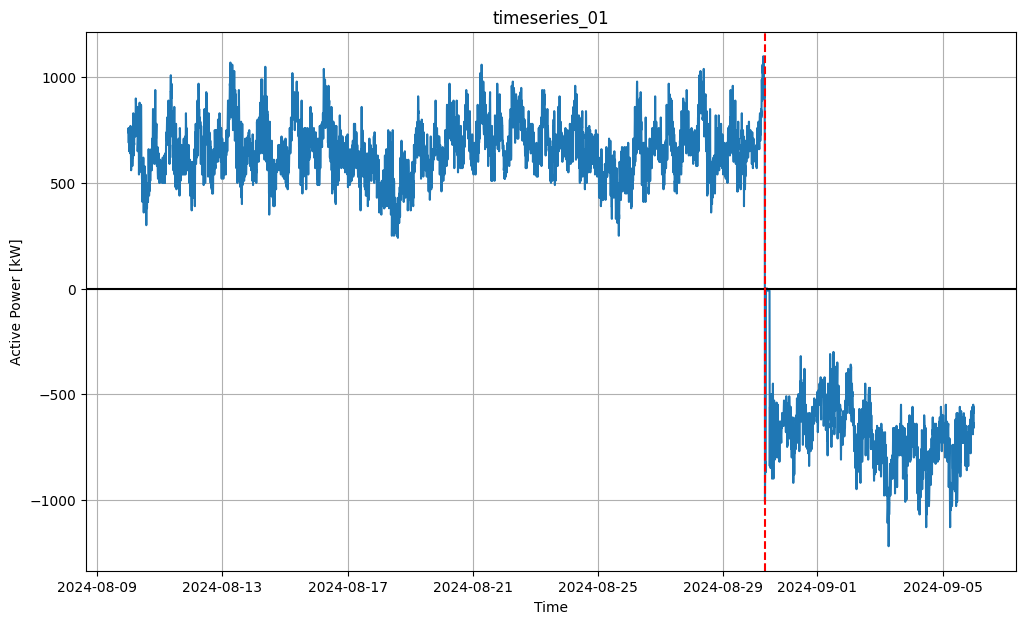

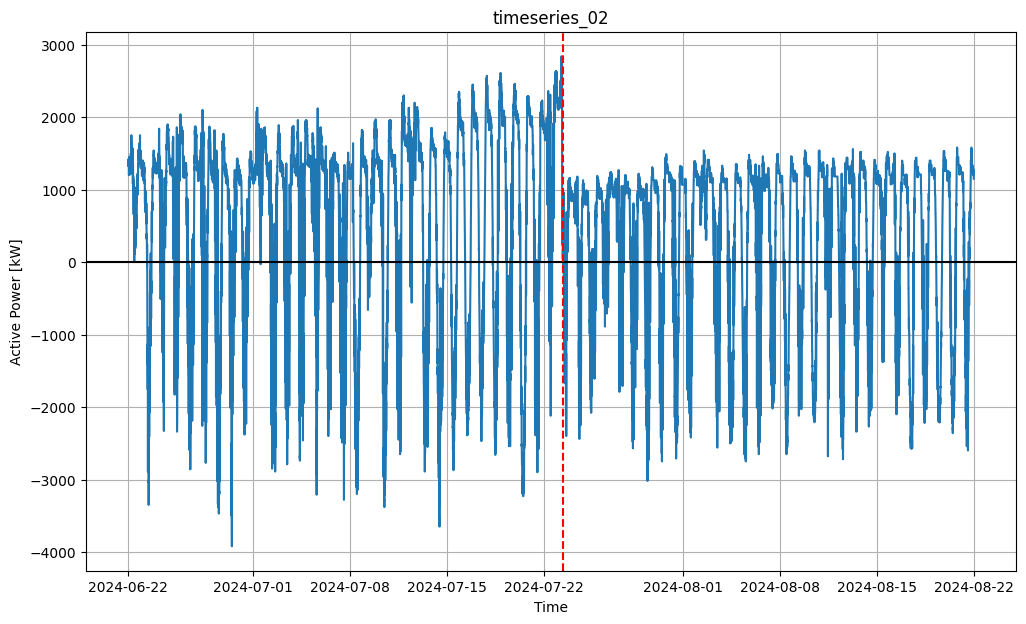

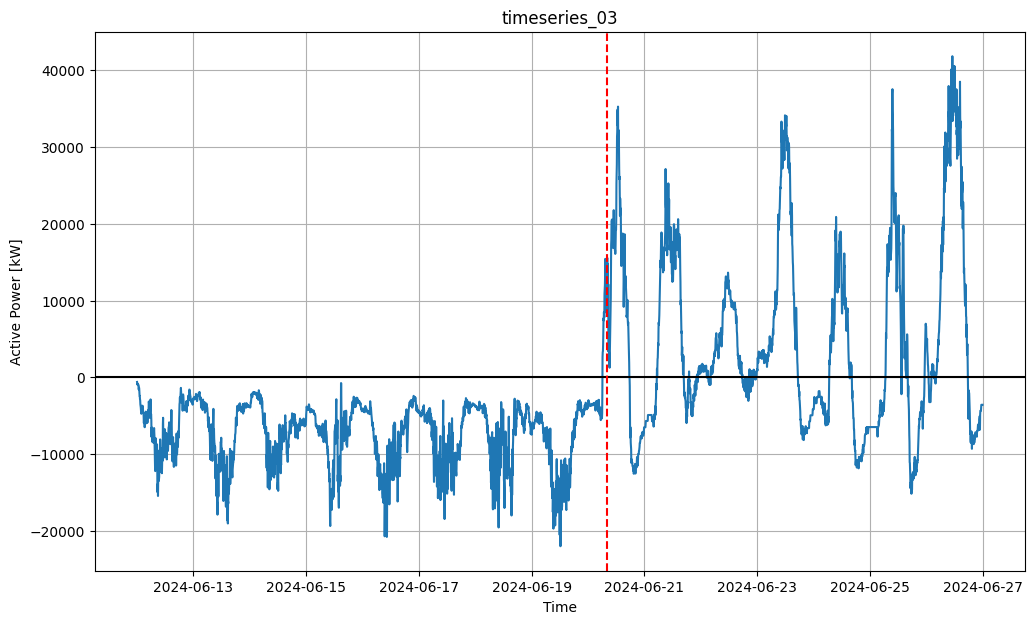

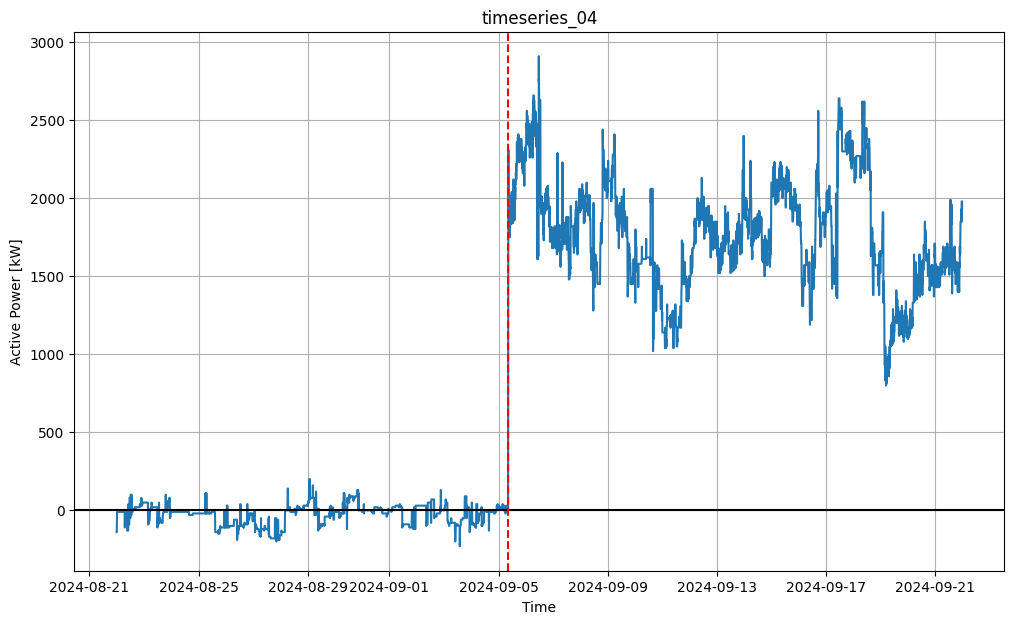

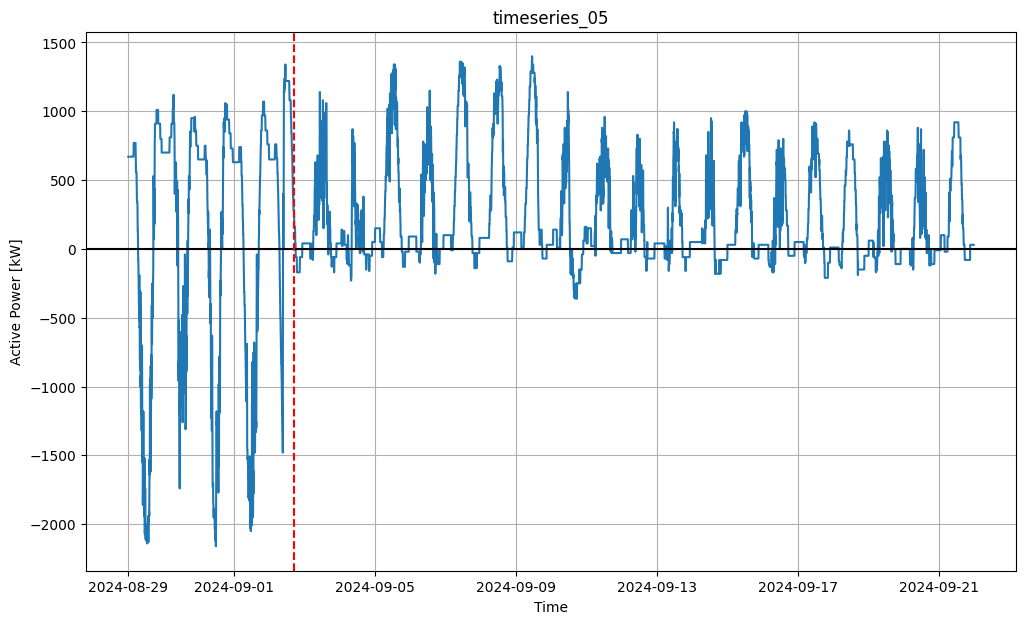

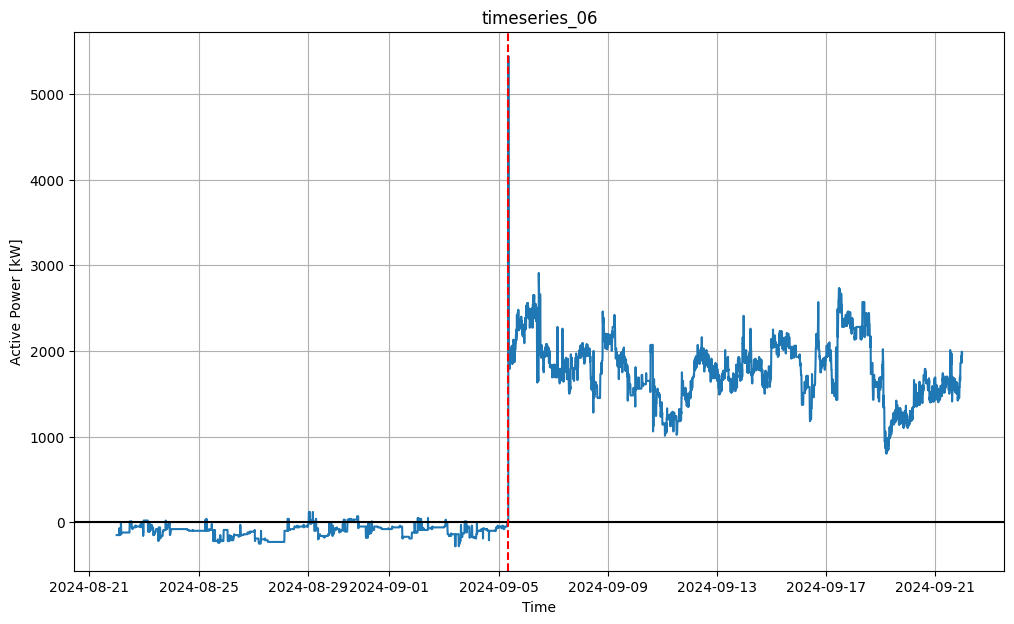

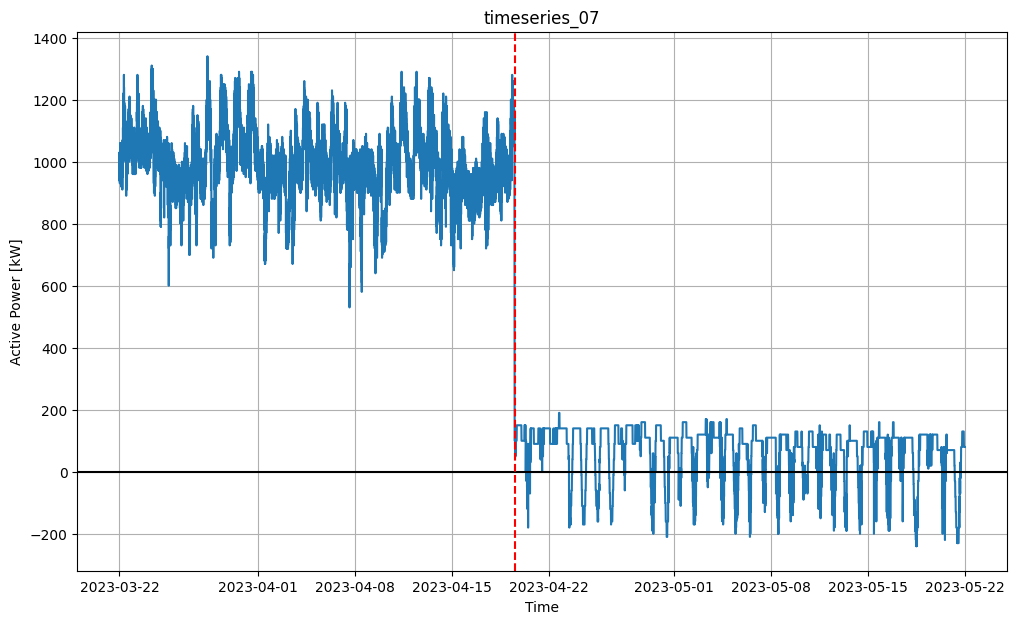

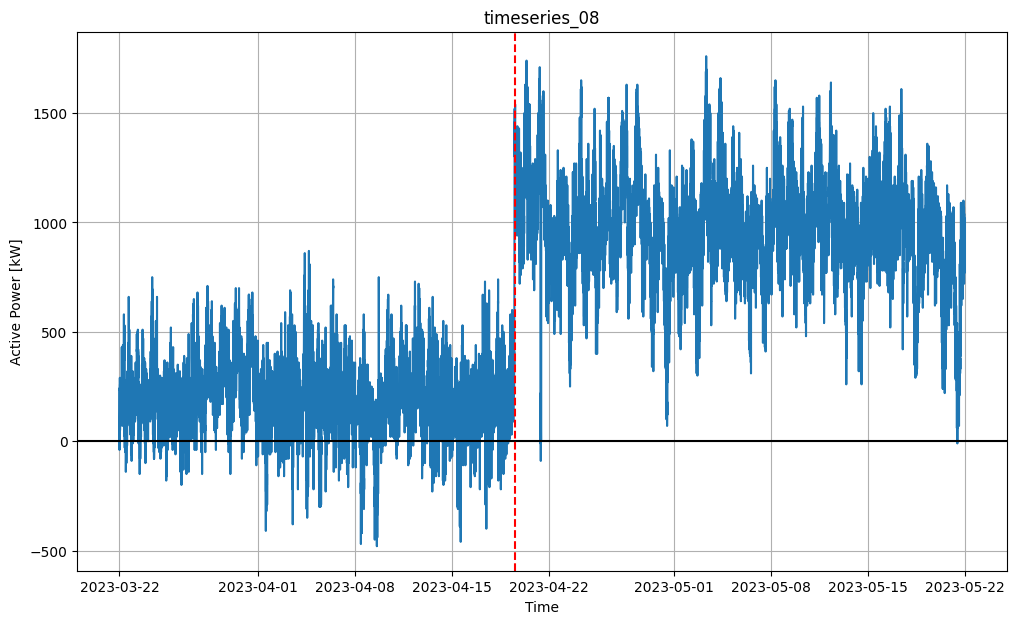

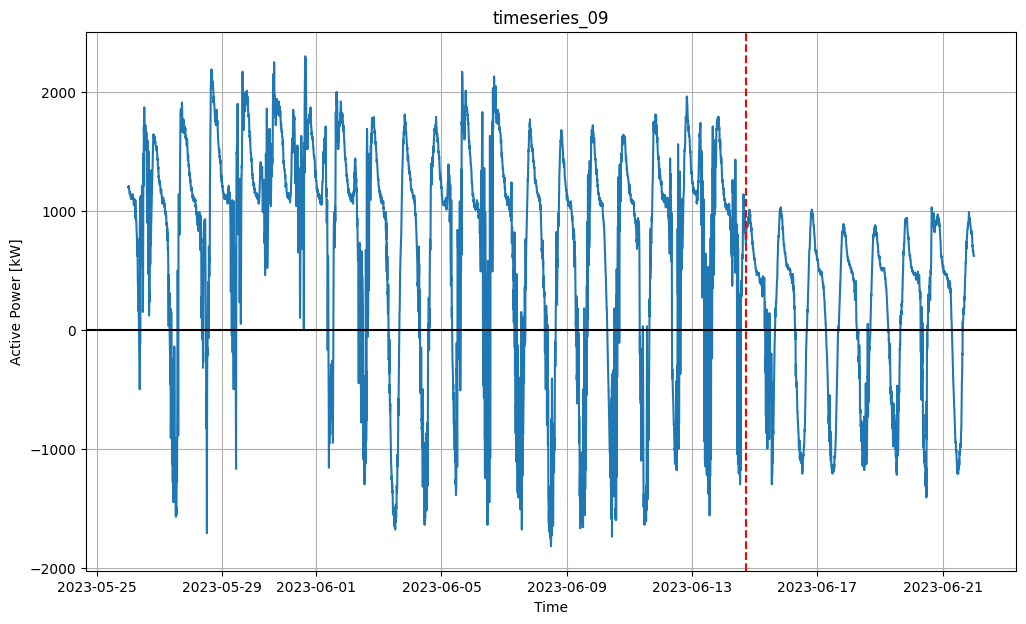

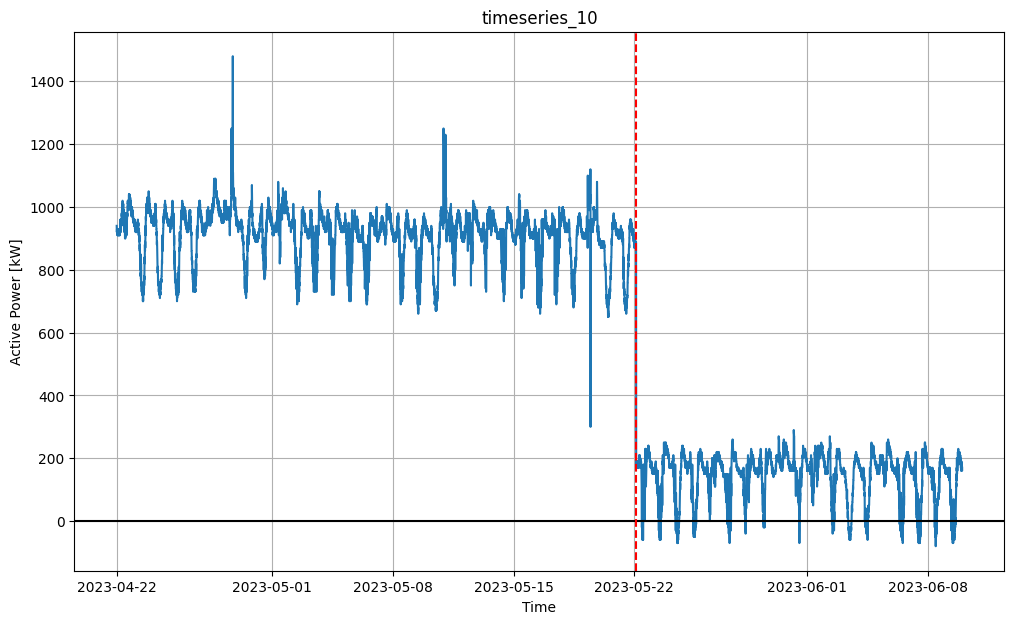

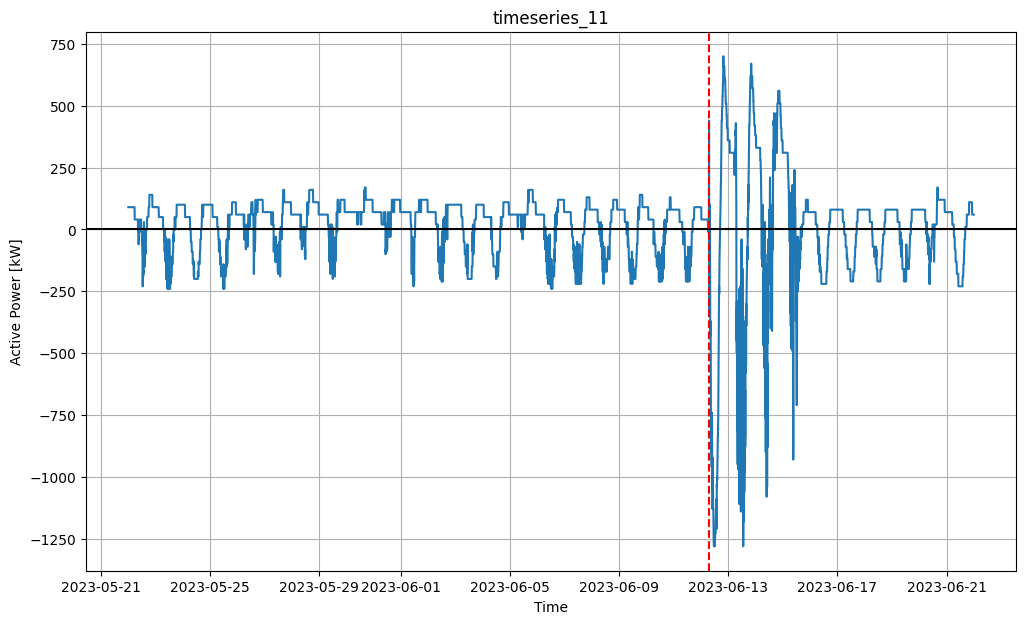

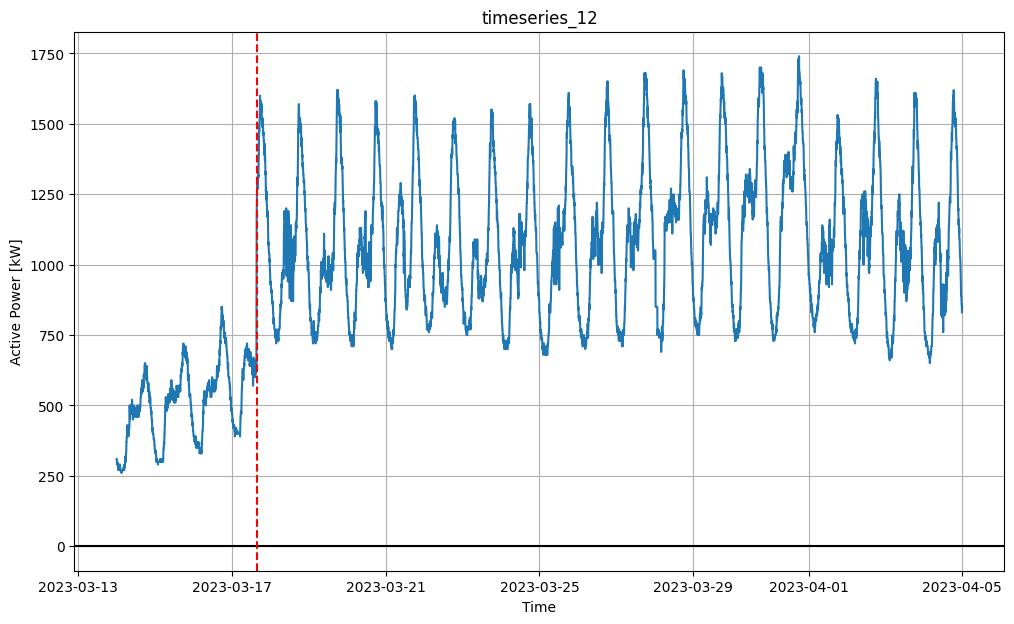

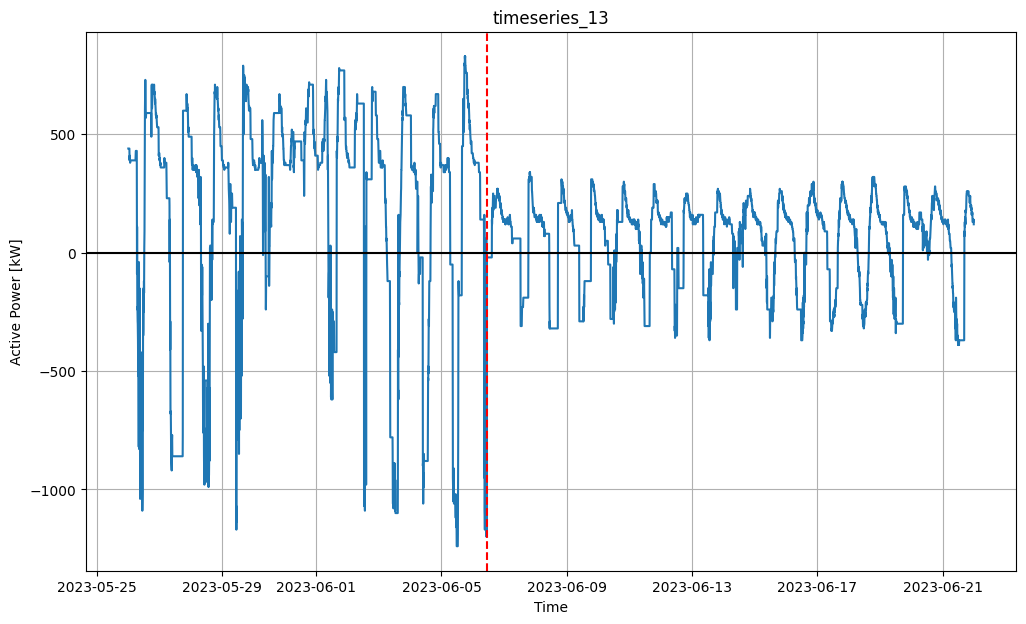

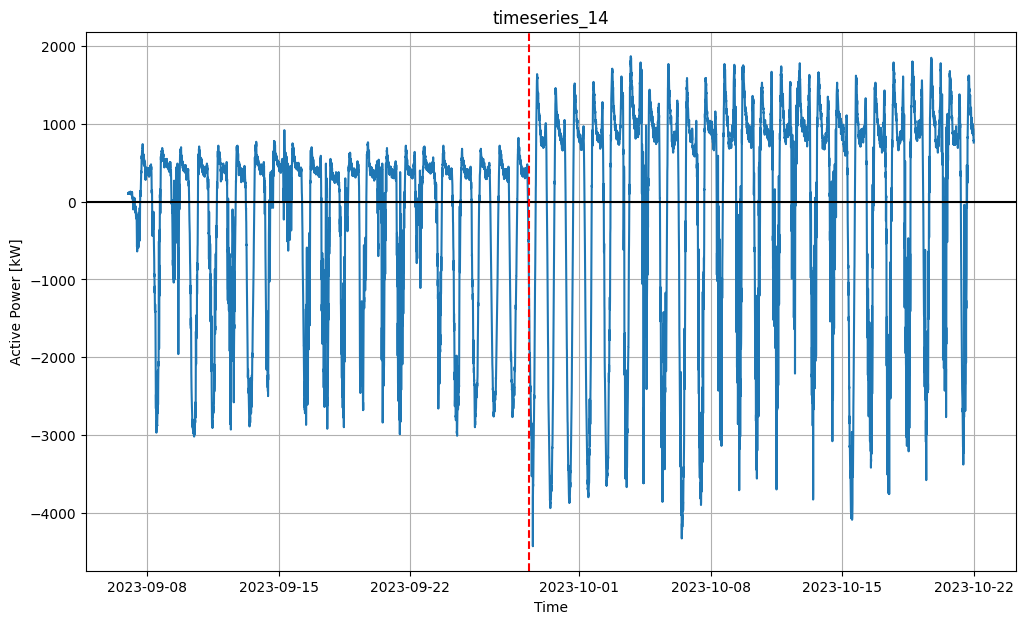

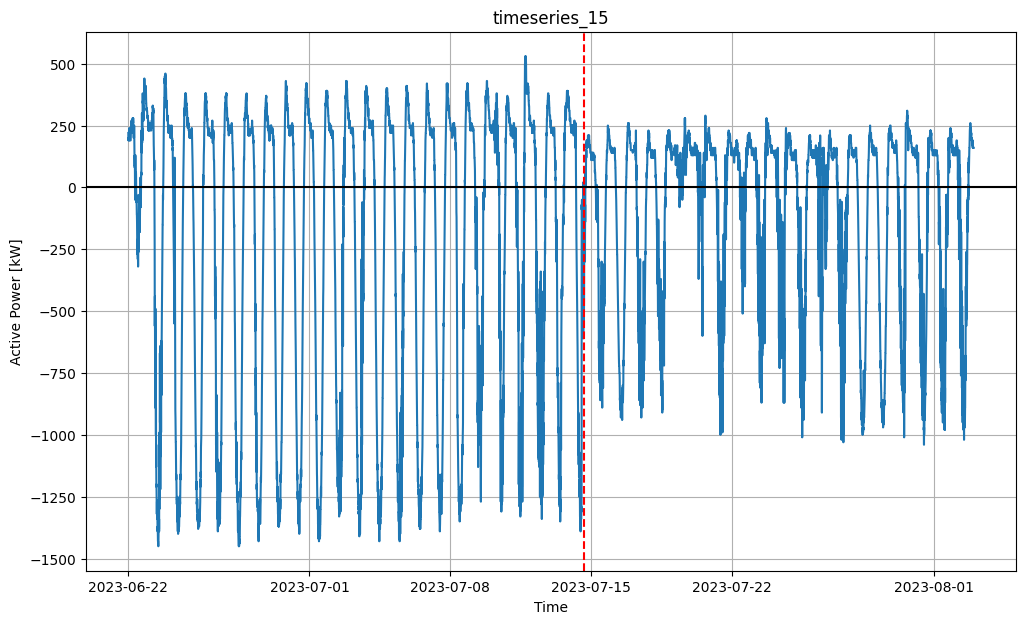

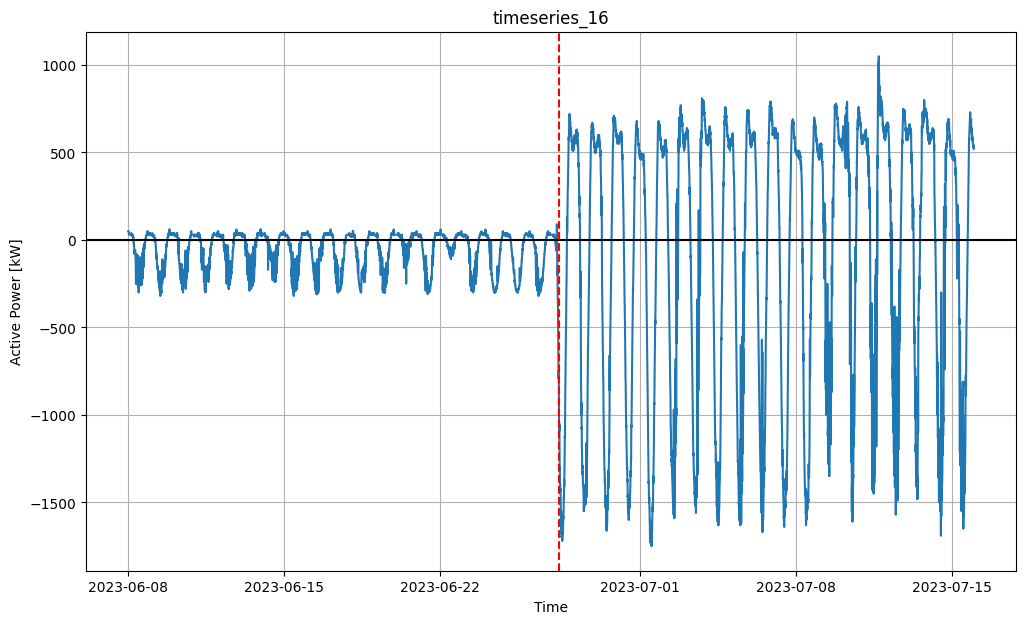

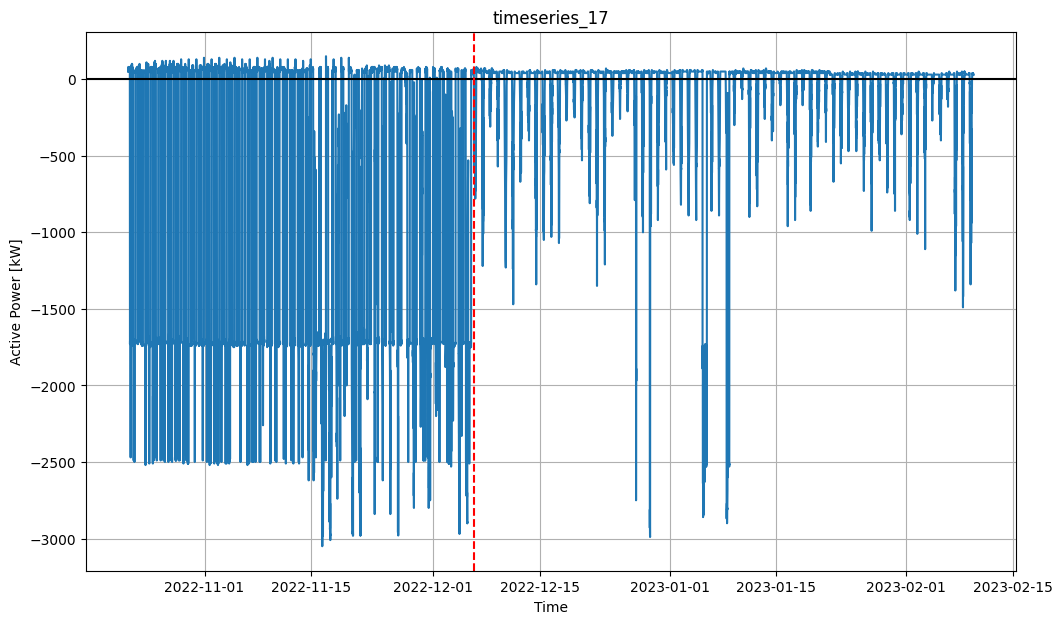

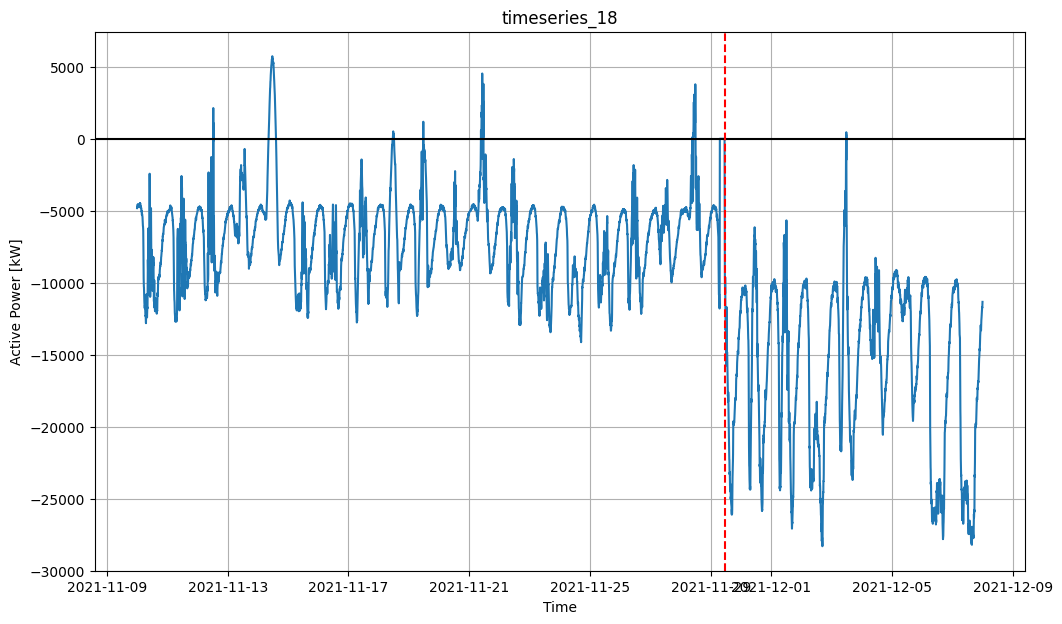

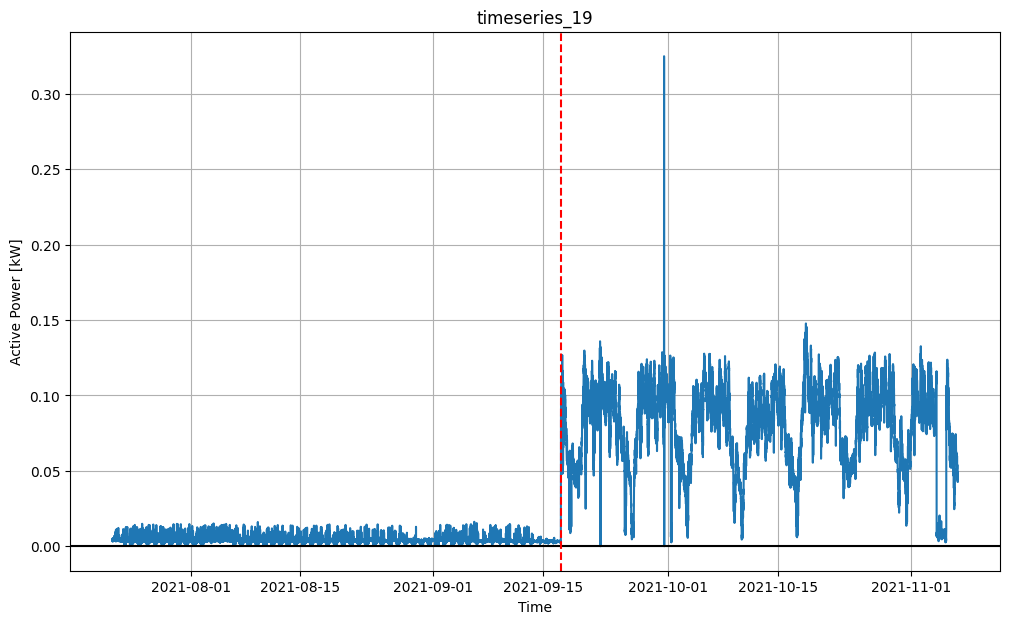

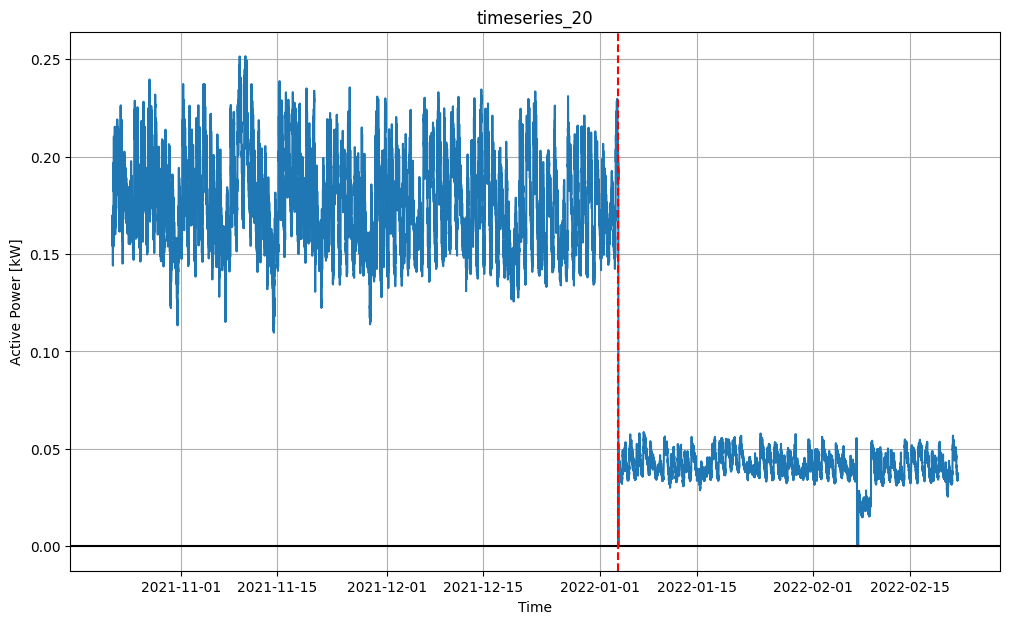

In [5]:
folder_name = './CHARGE_timeseries/'

folder_path = Path(folder_name)

for file in folder_path.iterdir():
    if file.is_file():

        timeseries_nr = file.name[:-5] # remove .xlsx

        data = pd.read_excel(file)


        fig = plt.figure(figsize=[12,7])

        plt.plot(pd.to_datetime(data.TIMESTAMP), data.VALUE)
        plt.grid()
        plt.axhline(0, color = "black")
        plt.title(timeseries_nr)
        plt.ylabel("Active Power [kW]")
        plt.xlabel("Time")
        plt.axvline(pd.to_datetime(change_points[timeseries_nr]), linestyle = "--", color = "red")
        plt.savefig("figures/ChangePoint_ts_"+str(timeseries_nr)+'.png')


# Gaussian Process

## Data

In [12]:
timeseries_1 = pd.read_excel("./CHARGE_timeseries/timeseries_01.xlsx")

In [13]:
timeseries_1

,VALUE,TIMESTAMP
0,740,2024-08-10 00:00:00
1,760,2024-08-10 00:05:00
2,760,2024-08-10 00:10:00
3,690,2024-08-10 00:15:00
4,690,2024-08-10 00:20:00
...,...,...
7764,-590,2024-09-05 23:35:00
7765,-560,2024-09-05 23:40:00
7766,-610,2024-09-05 23:45:00
7767,-660,2024-09-05 23:50:00


# Fit Gaussian Process

In [24]:
import gpflow
from sklearn.preprocessing import MinMaxScaler


In [25]:
X = timeseries_1["TIMESTAMP"].to_numpy().reshape(-1,1)
Y = timeseries_1["VALUE"].to_numpy().reshape(-1,1)

In [26]:
#k = gpflow.kernels.SquaredExponential()
base_k1 = gpflow.kernels.Matern32(lengthscales=0.2)
base_k2 = gpflow.kernels.Matern32(lengthscales=2.0)
k = gpflow.kernels.ChangePoints([base_k1, base_k2], [0.0], steepness=5.0)

2024-11-06 15:39:17.452514: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
model = gpflow.models.GPR(
    (X, Y),
    kernel=k,
)

ShapeMismatchError: 
Tensor shape mismatch.
  Function: GPR_deprecated.__init__
    Declared: /workspaces/Code/alliander-charge-course/.venv/lib/python3.12/site-packages/gpflow/models/gpr.py:59
    Argument: data
      Index: [0]
        Expected: [N, D]
        Actual:   [7769]
      Index: [1]
        Expected: [N, P]
        Actual:   [7769, 1]
    Argument: noise_variance
      Expected: []
      Actual:   <Tensor is None or has unknown shape>


In [ ]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)